In [66]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

import pandas as pd

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16}) #make plots more readable

import palettable as pal

import MagellanicStream as ms

import dlnpyutils

import warnings
warnings.filterwarnings('ignore')

###Machine Learning bit import
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score

In [67]:
##############################
### User defined functions ###
##############################

#find duplicates in data
def dups(data):
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

#calculate absolute mag
def absmag(magnitude,distance,par):
    ''' !!! Parallax must have units of mas and distances must have units of kpc!!! '''
    absm = []
    if par == True: #if distance is given as parallax
        dist = np.reciprocal(distance)*1000
        absm.append(magnitude-5.0*np.log10(dist)+5.0)
        absm = np.squeeze(np.array(absm))
    else: #if distance is given as distance
        absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
        absm = np.squeeze(np.array(absm))
    return absm

def LMCdisk_cart(ra, dec):
    
    '''
    Calculate the position of stars in the LMC disk plane with 
    center at the LMC center in cartesian coordinates (x, y).
    This also calculates the distance to the individual stars.
    
    This follows van der Marel and Cioni 2001 
    
    Input
    - ra: right ascension of stars
    - dec: declination of stars
    
    Output
    - x_m: x coordinate
    - y_m: y coordinate
    - dis: distance to LMC star
    '''
    alph0 = np.radians(82.25) #right ascension of center of LMC
    delt0 = np.radians(-69.50) #declination of center of LMC
    pa = np.radians(149.23+90.00) #146.37 #position angle of line of nodes
    io = np.radians(25.86) #27.81 #inclination of LMC disk
    d0 = 49.90 #distance to center of LMC
    
    #convert to radians
    ra = np.radians(ra)
    dec = np.radians(dec)
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    
    cr = cd*np.cos(dec)*np.cos(ra-alph0)+sd*np.sin(dec)
    srcp = -np.cos(dec)*np.sin(ra-alph0)
    srsp = cd*np.sin(dec) - sd*np.cos(dec)*np.cos(ra-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cr - np.sin(io)*np.cos(pa)*srsp + np.sin(io)*np.sin(pa)*srcp)
    
    x_m = dis*srcp
    y_m = dis*(np.cos(io)*srsp + np.sin(io)*cr) - d0*np.sin(io)
    
    return x_m, y_m, dis

def sal(MH,aM):
    return MH + np.log(0.638*(10**(aM))+0.362)

def mad(dat): #median absolute deviation
    return np.median(np.absolute(dat - np.median(dat)))

#######################
### Age of Universe ###
#######################

'''
@article{riess2019large,
  title={Large Magellanic Cloud Cepheid Standards Provide a 1\% Foundation for the Determination of the Hubble Constant and Stronger Evidence for Physics Beyond LambdaCDM},
  author={Riess, Adam G and Casertano, Stefano and Yuan, Wenlong and Macri, Lucas M and Scolnic, Dan},
  journal={arXiv preprint arXiv:1903.07603},
  year={2019}
}
'''

#Value 74.03 \pm 1.42 (km/s)/Mpc

H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [68]:
#########################
### Import fits files ###
#########################

#PARSEC Isochrones
'''
isochrone website http://stev.oapd.inaf.it/cgi-bin/cmd
Ages used 8 to 10.1 steps 0.15 
Metallicity used -2.6 to 0.1 steps 0.099
'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

#LMC r13 data
lmcr13 = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembers_r13-l33-58672.fits',1)
clnr = np.where((lmcr13['FE_H']>-9999.0)&(lmcr13['AK_TARG']>-9999.0)&(lmcr13['LOGG']>0.0)&
                (lmcr13['M_H_ERR']>-90.0)&(lmcr13['C_FE']>-9999.0)&(lmcr13['N_FE']>-9999.0))

r13 = lmcr13[clnr]

#LMC RGB DR16
dr16 = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembersdist_dr16beta.fits',1)
clnrr13 = np.where((dr16['FE_H']>-9999.0)&(dr16['AK_TARG']>-9999.0)&(dr16['LOGG']>0.0)&
                   (dr16['M_H_ERR']>-90.0)&(dr16['C_FE']>-9999.0)&(dr16['N_FE']>-9999.0))

clndr16 = dr16[clnrr13]

#Diane Feuillet Bayesian Ages
pdfout = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/LMC_DR16_all_PDF.fits', 1)
clnpdfout = pdfout[ np.where((dr16['FE_H']>-9999.0)&(dr16['AK_TARG']>-9999.0)&(dr16['LOGG']>0.0)&
                             (dr16['M_H_ERR']>-90.0)&(dr16['C_FE']>-9999.0)&(dr16['N_FE']>-9999.0))]

In [69]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense


In [70]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

y_par = parsec['logAge']
x1 = parsec['logTe'] 
x2 = parsec['Ksmag']
x3 = np.log10(parsec['Zini']/0.02)
x4 = parsec['logg']

X_par =np.array([x1,x2,x3,x4]).T

X_train, X_test, y_train, y_test = train_test_split(X_par, y_par, test_size = 0.5)

In [50]:
# Feature Scaling
# from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [71]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense

In [77]:
model = Sequential()
model.add(Dense(12, input_dim=4, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 12)                60        
_________________________________________________________________
dense_26 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 9         
Total params: 173
Trainable params: 173
Non-trainable params: 0
_________________________________________________________________


In [78]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

In [79]:
history = model.fit(X_train, y_train, epochs=150, batch_size=50,  verbose=1, validation_split=0.2)

Train on 6448 samples, validate on 1612 samples
Epoch 1/150
6448/6448 [==============================] - 0s 65us/step - loss: 65.4436 - mse: 65.4436 - mae: 8.0090 - val_loss: 37.1816 - val_mse: 37.1816 - val_mae: 6.0506
Epoch 2/150
6448/6448 [==============================] - 0s 50us/step - loss: 14.8924 - mse: 14.8924 - mae: 3.4564 - val_loss: 2.6708 - val_mse: 2.6708 - val_mae: 1.3387
Epoch 3/150
6448/6448 [==============================] - 0s 51us/step - loss: 1.7610 - mse: 1.7610 - mae: 1.0547 - val_loss: 1.5229 - val_mse: 1.5229 - val_mae: 0.9654
Epoch 4/150
6448/6448 [==============================] - 0s 47us/step - loss: 1.3903 - mse: 1.3903 - mae: 0.9323 - val_loss: 1.2865 - val_mse: 1.2865 - val_mae: 0.8911
Epoch 5/150
6448/6448 [==============================] - 0s 51us/step - loss: 1.1809 - mse: 1.1809 - mae: 0.8606 - val_loss: 1.1053 - val_mse: 1.1053 - val_mae: 0.8344
Epoch 6/150
6448/6448 [==============================] - 0s 43us/step - loss: 1.0227 - mse: 1.0227 - mae: 

6448/6448 [==============================] - 0s 36us/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0475 - val_loss: 0.0034 - val_mse: 0.0034 - val_mae: 0.0475
Epoch 50/150
6448/6448 [==============================] - 0s 41us/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0476 - val_loss: 0.0035 - val_mse: 0.0035 - val_mae: 0.0482
Epoch 51/150
6448/6448 [==============================] - 0s 65us/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0479 - val_loss: 0.0035 - val_mse: 0.0035 - val_mae: 0.0477
Epoch 52/150
6448/6448 [==============================] - 0s 31us/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0489 - val_loss: 0.0035 - val_mse: 0.0035 - val_mae: 0.0489
Epoch 53/150
6448/6448 [==============================] - 0s 30us/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0487 - val_loss: 0.0037 - val_mse: 0.0037 - val_mae: 0.0488
Epoch 54/150
6448/6448 [==============================] - 0s 30us/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0478 - val_loss: 0.0038 - val_mse: 0.0038 - val_mae: 0.0490

6448/6448 [==============================] - 0s 48us/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0488 - val_loss: 0.0036 - val_mse: 0.0036 - val_mae: 0.0483
Epoch 98/150
6448/6448 [==============================] - 0s 34us/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0475 - val_loss: 0.0036 - val_mse: 0.0036 - val_mae: 0.0493
Epoch 99/150
6448/6448 [==============================] - 0s 41us/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0497 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0495
Epoch 100/150
6448/6448 [==============================] - 0s 39us/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0486 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0554
Epoch 101/150
6448/6448 [==============================] - 0s 32us/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0479 - val_loss: 0.0037 - val_mse: 0.0037 - val_mae: 0.0502
Epoch 102/150
6448/6448 [==============================] - 0s 30us/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0482 - val_loss: 0.0035 - val_mse: 0.0035 - val_mae: 0.0

6448/6448 [==============================] - 0s 46us/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0481 - val_loss: 0.0037 - val_mse: 0.0037 - val_mae: 0.0506
Epoch 146/150
6448/6448 [==============================] - 0s 40us/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0476 - val_loss: 0.0035 - val_mse: 0.0035 - val_mae: 0.0483
Epoch 147/150
6448/6448 [==============================] - 0s 40us/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0483 - val_loss: 0.0034 - val_mse: 0.0034 - val_mae: 0.0472
Epoch 148/150
6448/6448 [==============================] - 0s 41us/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0477 - val_loss: 0.0041 - val_mse: 0.0041 - val_mae: 0.0499
Epoch 149/150
6448/6448 [==============================] - 0s 47us/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0477 - val_loss: 0.0033 - val_mse: 0.0033 - val_mae: 0.0469
Epoch 150/150
6448/6448 [==============================] - 0s 52us/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0480 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0

dict_keys(['val_loss', 'val_mse', 'val_mae', 'loss', 'mse', 'mae'])


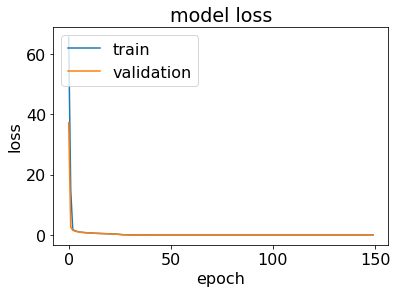

In [80]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Xnew = np.array([[40, 0, 26, 9000, 8000]])
# X_test = scaler_x.transform(X_test)
y_new = model.predict(X_test)
#invert normalize
# y_new = scaler_y.inverse_transform(y_new) 
# Xnew = scaler_x.inverse_transform(Xnew)
# print("X=%s, Predicted=%s" % (Xnew[0], ynew[0]))

plt.hist(y_new-y_test)

In [38]:
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

ValueError: Classification metrics can't handle a mix of continuous and binary targets

(array([   0.,    0.,    0.,    0.,    0., 3225.,    0.,    0.,    0.,
           0.]), array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5],
       dtype=float32), <a list of 10 Patch objects>)

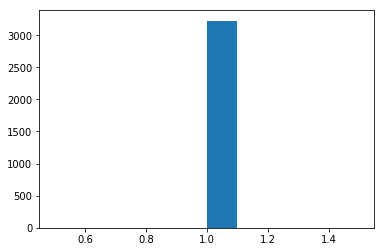

In [40]:
plt.hist(y_pred)

In [59]:
import numpy as np

class NeuralNetwork():
    
    def __init__(self):
        # seeding for random number generation
        np.random.seed(1)
        
        #converting weights to a 3 by 1 matrix with values from -1 to 1 and mean of 0
        self.synaptic_weights = 2 * np.random.random((3, 1)) - 1

    def sigmoid(self, x):
        #applying the sigmoid function
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        #computing derivative to the Sigmoid function
        return x * (1 - x)

    def train(self, training_inputs, training_outputs, training_iterations):
        
        #training the model to make accurate predictions while adjusting weights continually
        for iteration in range(training_iterations):
            #siphon the training data via  the neuron
            output = self.think(training_inputs)

            #computing error rate for back-propagation
            error = training_outputs - output
            
            #performing weight adjustments
            adjustments = np.dot(training_inputs.T, error * self.sigmoid_derivative(output))

            self.synaptic_weights += adjustments

    def think(self, inputs):
        #passing the inputs via the neuron to get output   
        #converting values to floats
        
        inputs = inputs.astype(float)
        output = self.sigmoid(np.dot(inputs, self.synaptic_weights))
        return output


if __name__ == "__main__":

    #initializing the neuron class
    neural_network = NeuralNetwork()

    print("Beginning Randomly Generated Weights: ")
    print(neural_network.synaptic_weights)

    #training data consisting of 4 examples--3 input values and 1 output
    training_inputs = X_train.T #np.array([[0,0,1],
                                #[1,1,1],
                                #[1,0,1],
                                #[0,1,1]])

    training_outputs = y_train #np.array([[0,1,1,0]]).T

    #training taking place
    neural_network.train(training_inputs, training_outputs, 15000)

    print("Ending Weights After Training: ")
    print(neural_network.synaptic_weights)

    user_input_one = str(input("User Input One: "))
    user_input_two = str(input("User Input Two: "))
    user_input_three = str(input("User Input Three: "))
    
    print("Considering New Situation: ", user_input_one, user_input_two, user_input_three)
    print("New Output data: ")
    print(neural_network.think(np.array([user_input_one, user_input_two, user_input_three])))
    print("Wow, we did it!")


Beginning Randomly Generated Weights: 
[[-0.16595599]
 [ 0.44064899]
 [-0.99977125]]


ValueError: shapes (4,8060) and (3,1) not aligned: 8060 (dim 1) != 3 (dim 0)

In [64]:
nn_age = []
for i in range(len(r13)):
    euclid = []
    for j in range(len(parsec)):
        euclid.append(np.sqrt((np.log10(r13['TEFF'][i])-parsec['logTe'][j])**2+
                              (r13['K'][i]-parsec['Ksmag'][j])**2+
                              (r13['FE_H'][i]-np.log10(parsec['Zini'][j]/0.02))**2+
                              (r13['LOGG'][i]-parsec['logg'][j])**2))
    idx = np.asarray(euclid).argmin()
    nn_age.append(parsec['logAge'][idx])

(array([   0.,    0.,    0.,    0.,    0., 2427.,    0.,    0.,    0.,
           0.]),
 array([ 9.6,  9.7,  9.8,  9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6]),
 <a list of 10 Patch objects>)

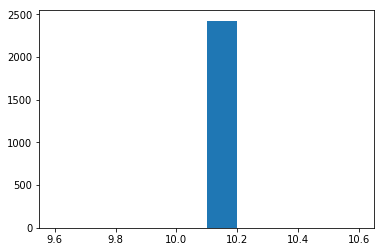

In [65]:
plt.hist(nn_age)